First, packages are imported.

In [1]:
#   import packages
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import networkx as nx
import pickle
import functools

from ema_workbench import (
    Model,
    Policy,
    Scenario,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    util,
    ScalarOutcome,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress
from ema_workbench.em_framework import parameters_from_csv
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import prim
from ema_workbench import Samplers

### Choice of robustness metrics:


| Robustness metric 	 |    kind 	     |
|:-------------------:|:-------------:|
|   Damage Cost          	   | Minimize    	 |
|          	Deaths Score          |       	Minimize       |
|          	 Dike Invest Cost         |       	Minimize       |
|          RfR Invest Cost       |       	Minimize       |
|          	Evacuation Cost        |       	Minimize       |

Robustness score calculation:

Then, the model is loaded, and logging is set.

In [2]:
dike_model, planning_steps = get_model_for_problem_formulation(5)
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

The results from the basecase open exploration, which includes the worst scenarios, are loaded into a Pandas DataFrame.

In [32]:
open_exploration_results = pd.read_pickle(r'generated_datasets\open_exploration_base_policy_worst_scenarios.pkl')

To calculate the robustness metrics, which are defined as the total annual damage, total expected number of deaths, total dike investment costs, total room for the river costs and total expected evacuation costs, lists of these variables are saved for later use.

In [4]:
# List the names of vars to make `robustness_functions` a bit more read-able
damage_overijssel = ['A.4_Expected Annual Damage', 'A.5_Expected Annual Damage',]
deaths_overijssel = ['A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths',]
dike_investments_overijssel = ['A.4_Dike Investment Costs', 'A.5_Dike Investment Costs',]
var_list_rfr = ['RfR Total Costs',]
var_list_evac = ['Expected Evacuation Costs',]

Then, the robustness metric is initiated into a function. For this, we chose LEG UIT.
Furthermore, maximalization and minimalization functions are initiated to use in the optimization process.

In [5]:
# Mean square deviation

def robust_sum(*data):
    sumsumsum = sum(sum(sum(data)))

    mean = np.mean(sumsumsum)
    iqr = sp.stats.iqr(sumsumsum) # + mean * 0.001
    result = np.square(mean) + np.square(iqr)

    return result

Then, we make the robustness functions and add constraints. We chose minimize and maximize, most conservative (Kwakkel, J. H., Eker, S., & Pruyt, E. (2016). How robust is a robust policy? Comparing alternative robustness metrics for robust decision-making. Robustness analysis in decision aiding, optimization, and analytics, 221-237.)

In [6]:
# robustness metrics
maximize = ScalarOutcome.MAXIMIZE
minimize = ScalarOutcome.MINIMIZE

robustness_functions = [
    ScalarOutcome('Damage Cost',
                  variable_name=damage_overijssel,
                  function=robust_sum,
                  kind=minimize,
                  ),
    ScalarOutcome('Deaths Score',
                  variable_name=deaths_overijssel,
                  function=robust_sum,
                  kind=minimize,
                  ),
    ScalarOutcome('Dike Invest Cost',
                  variable_name=dike_investments_overijssel,
                  function=robust_sum,
                  kind=minimize,
                  ),
    ScalarOutcome("RfR Invest Cost",
                  kind=minimize,
                  function=robust_sum,
                  variable_name="RfR Total Costs"),
    ScalarOutcome("Evacuation Cost",
                  kind=minimize,
                  function=robust_sum,
                  variable_name="Expected Evacuation Costs"),
]

These scenarios are then loaded into a model variable.

In [7]:
scenarios = []
for row_number in range(open_exploration_results.shape[0]):
    scenarios.append(
        Scenario(name=row_number, **open_exploration_results.iloc[row_number, :16].to_dict())
    )

Convergence metrics are loaded

In [8]:
convergence_metrics = [
    ArchiveLogger(
        "./archives",
        [l.name for l in dike_model.levers],
        [o.name for o in robustness_functions],
        base_filename="robust_optimization_test.tar.gz",
    ),
    EpsilonProgress(),
]

Finally, the model variables are set.

In [9]:
# general input
nfe = int(25) #make this large (2e5)
epsilons = [0.05, ]*len(robustness_functions)


Then, the model can be run. Results (pareto set of policies) are saved.

In [10]:
# Run MORO
with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.robust_optimize(robustness_functions,
                                                     scenarios=scenarios,
                                                     nfe=nfe,
                                                     epsilons=epsilons,
                                                     convergence=convergence_metrics,
                                                     population_size=5,
                                                     )

with open(r'generated_datasets/initial_Pareto_policies_test.pkl', 'wb') as file_pi:
    pickle.dump(results, file_pi)

[MainProcess/INFO] pool started with 12 workers
28it [00:55,  1.97s/it]                                                        
[MainProcess/INFO] optimization completed, found 9 solutions
[MainProcess/INFO] terminating pool


Now, we can continue with the visualization.

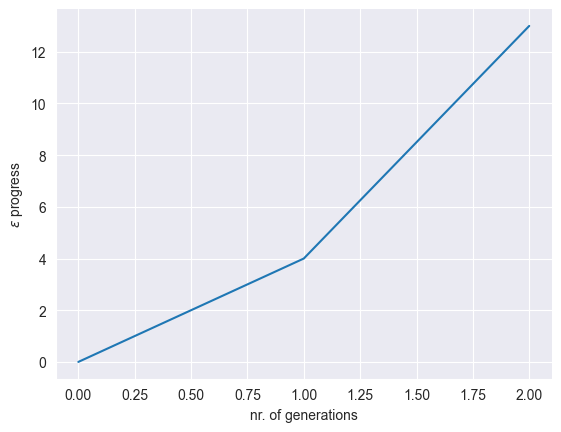

In [11]:
plt.plot(convergence.epsilon_progress)
plt.xlabel("nr. of generations")
plt.ylabel(r"$\epsilon$ progress")
sns.despine()
plt.savefig(r'figures/MORO/epsilon_progress_robust_optimize.png', bbox_inches='tight')
plt.show()
sns.set(rc={'figure.figsize':(12,6)})


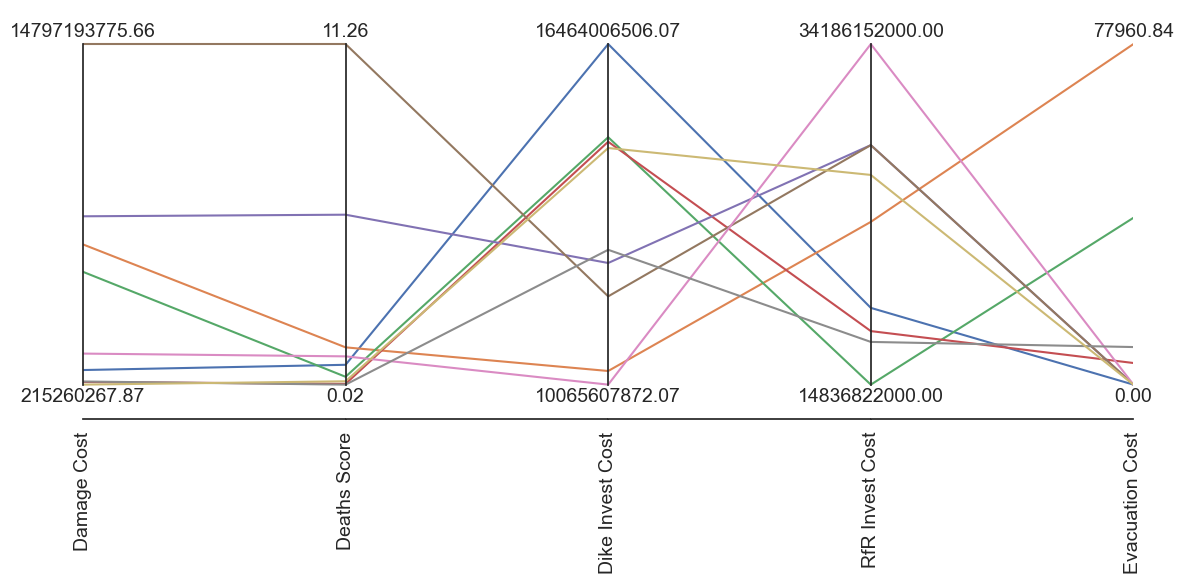

In [12]:
df = pd.read_pickle(r'generated_datasets/initial_Pareto_policies_test.pkl')

data = df.loc[:, [o.name for o in robustness_functions]]
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
sns.despine()
plt.savefig(r'figures/MORO/pareto_visualization.png', bbox_inches='tight')
sns.set(rc={'figure.figsize':(12,6)})

# Scenarios discovery of pareto policies
In this analysis, the pareto set of policies is tested on a set of 10.000 scenarios, covering the full uncertainty space.

First, the results of the policy discovery is loaded.

In [13]:
pareto_policies = pd.read_pickle(r'generated_datasets/initial_Pareto_policies_test.pkl')

Then, the policies from the analysis are loaded into the model.

In [14]:
policies = []
for row_number in range(pareto_policies.shape[0]):
    policies.append(
        Policy(name=row_number, **pareto_policies.iloc[row_number, :-5].to_dict())
    )

General settings of the model are set.

In [15]:
n_scenarios = 50 # maak 10.000

Then, run the model with the robust policies as input, and generate results over a lot of scenarios

In [16]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenarios,
                                            policies=policies,
                                            uncertainty_sampling=Samplers.LHS
                                            )

with open(r'generated_datasets/policy_test_all_scenarios.pkl', 'wb') as file_pi:
    pickle.dump(results, file_pi)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 50 scenarios * 9 policies * 1 model(s) = 450 experiments
100%|████████████████████████████████████████| 450/450 [00:45<00:00,  9.94it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


The results are then loaded in for analysis

In [17]:
scenario_results = pd.read_pickle(r'generated_datasets/policy_test_all_scenarios.pkl')
experiments, outcomes = results

Make a dataframe column for every timestep of the results.

In [18]:
policies_all_scenarios = pd.DataFrame()
for key, value in outcomes.items():
    temp_df = pd.DataFrame(value, columns=[key + ' '+ str(x) for x in range(len(value[0]))])
    policies_all_scenarios = pd.concat([policies_all_scenarios, temp_df], axis=1)

Add experiments input to the outputs for analysis

In [19]:
experiments_and_results = pd.concat([experiments,policies_all_scenarios], axis=1)

Combine the variables of different dikes and times

In [20]:
def combine_columns(dataframe, name):
    combined_columns = []
    for x in dataframe.columns:
        if name in x:
            combined_columns.append(x)

    dataframe['Total ' + str(name)] = dataframe[combined_columns].sum(axis=1)

In [21]:
combine_columns(policies_all_scenarios, 'Expected Annual Damage')
combine_columns(policies_all_scenarios, 'Dike Investment Costs')
combine_columns(policies_all_scenarios, 'Expected Number of Deaths')
combine_columns(policies_all_scenarios, 'RfR Total Costs')
combine_columns(policies_all_scenarios, 'Expected Evacuation Costs')

Generate statistics

In [22]:
aggregated_outcomes = pd.concat([experiments[['scenario','policy']],policies_all_scenarios.iloc[:,-5:]], axis=1)

stats_df = pd.DataFrame()
for column in aggregated_outcomes.iloc[:,2:].columns:
    stats_df[column + ' mean'] = aggregated_outcomes.groupby('policy').agg({column:['mean']})
    stats_df[column + ' std'] = aggregated_outcomes.groupby('policy').agg({column:['std']})

A plot with the means and standard deviations of the policies is made, to check reliabilities of the results

Boxplots and barplots are made to compare the results of the policies.

## mass generation of plots

Mean + std plots:

In [23]:
for var in aggregated_outcomes.iloc[:,2:].columns:
    var_path = str('figures/scenario_discovery/policy_' + var + '_mean_std_plot.png')
    (
    so.Plot(aggregated_outcomes, y=var, x="policy")
    .add(so.Dot(),so.Agg())
    .add(so.Range(),so.Est(errorbar="sd"))
    .layout(size=(12, 6))
    .save(var_path)
    )

Boxplots:

In [24]:
for var in aggregated_outcomes.iloc[:,2:].columns:
    var_path = str('figures/scenario_discovery/policy_' + var + '_boxplot.png')
    img = sns.boxplot(aggregated_outcomes, y=var, x="policy")
    sns.set(rc={'figure.figsize': (12, 6)})
    fig = img.get_figure()
    fig.savefig(var_path, bbox_inches='tight')
    fig.clf()

<Figure size 1200x600 with 0 Axes>

prim plots:

In [25]:
x = experiments_and_results.iloc[:,:19]

for var in aggregated_outcomes.iloc[:,2:].columns:
    var_path = str('figures/scenario_discovery/policy_' + var + '_PRIM.png')

    y_total_damage = aggregated_outcomes[var].values
    y_total_damage = y_total_damage > np.percentile(y_total_damage, 75)

    prim_alg_DAM = prim.Prim(x,
                     y_total_damage,
                     threshold=0.75,
                     peel_alpha=0.05,) # deze variabelen nog tweaken
    box_DAM = prim_alg_DAM.find_box()

    img = box_DAM.show_tradeoff()
    plt.title(var)
    fig = img.get_figure()
    fig.savefig(var_path, bbox_inches='tight')
    fig.clf()

[MainProcess/INFO] 450 points remaining, containing 113 cases of interest
[MainProcess/INFO] mean: 0.9259259259259259, mass: 0.06, coverage: 0.22123893805309736, density: 0.9259259259259259 restricted_dimensions: 11
[MainProcess/INFO] 450 points remaining, containing 100 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.2222222222222222, returning dump box
[MainProcess/INFO] 450 points remaining, containing 113 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.6666666666666666, returning dump box
[MainProcess/INFO] 450 points remaining, containing 50 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.1111111111111111, returning dump box
[MainProcess/INFO] 450 points remaining, containing 113 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.4444444444444444, returning dump box


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

### Gelderland - Overijssel Split

In [26]:
def combine_columns_province(dataframe, name):
    combined_columns_gelderland = []
    combined_columns_overijssel = []
    for x in dataframe.columns:
        if name in x:
            if x.startswith('A.1') or x.startswith('A.2') or x.startswith('A.3'):
                combined_columns_gelderland.append(x)
            if x.startswith('A.4') or x.startswith('A.5'):
                combined_columns_overijssel.append(x)

    dataframe['Total ' + str(name) + ' Gelderland'] = dataframe[combined_columns_gelderland].sum(axis=1)
    dataframe['Total ' + str(name) + ' Overijssel'] = dataframe[combined_columns_overijssel].sum(axis=1)

In [27]:
provinces = policies_all_scenarios.copy()

combine_columns_province(provinces, 'Expected Annual Damage')
combine_columns_province(provinces, 'Dike Investment Costs')
combine_columns_province(provinces, 'Expected Number of Deaths')
combine_columns_province(provinces, 'RfR Total Costs')
combine_columns_province(provinces, 'Expected Evacuation Costs')

In [28]:
aggregated_outcomes_provinces = pd.concat([experiments[['scenario','policy']],provinces.iloc[:,-10:]], axis=1)

In [29]:
for var in aggregated_outcomes.iloc[:,2:].columns:
    var_path = str('figures/scenario_discovery/policy_provinces_' + var + '_boxplot.png')
    fig, ax = plt.subplots(1,2, sharey=True)

    y_gelderland = str(var + ' Gelderland')
    y_overijssel = str(var + ' Overijssel')

    sns.boxplot(aggregated_outcomes_provinces, y=y_gelderland, x="policy", ax=ax[0])
    sns.boxplot(aggregated_outcomes_provinces, y=y_overijssel, x="policy", ax=ax[1])
    sns.set(rc={'figure.figsize': (12, 6)})
    fig.tight_layout()
    fig.savefig(var_path, bbox_inches='tight')
    fig.clf()

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>